# Sampling of tropical marine cloud-radiative effects and cloud cover as a function of pressure velocity at 500hPa

This notebook reproduces Figure 1b. The sampling time-scale is monthly.

Data: ERA-Interim for omega at 500hPa. CERES EBAF edition 4.1 for cloud-radiative effects. CALIPSO-GOCCP for cloud cover. ERA-Interim and CALIPSO-GOCCP have been interpolated to the CERES EBAF horizontal grid.

### Load libraries

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

For reference, print package versions to screen

In [2]:
print('xarrary:   ', xr.__version__)
print('numpy:     ', np.__version__)
import matplotlib; print('matplotlib:', matplotlib.__version__); del matplotlib

xarrary:    0.15.1
numpy:      1.18.1
matplotlib: 3.2.1


### Load data for common years 2007-2018

Note that for CALIPSO-GOCCP, February 2016 is missing, so this month is also excluded for ERA-Interim and CERES EBAF.

ERA-Interim:

In [3]:
omega = ( xr.load_dataset('../../data/obs/ERAI_omega500_monthly_2007-2018.remapcon_ceresgrid.nc')
         [['initial_time0_hours', 'lat', 'lon', 'W_GDS4_ISBL_S123']].
         rename({'initial_time0_hours':'time', 'W_GDS4_ISBL_S123':'omega'}) )
# convert omega from Pa/s to hPa/day
omega['omega'] = omega['omega']*86400/100
#exclude February 2016
omega = omega.sel(time=~((omega.time.dt.year == 2016) & (omega.time.dt.month == 2)))

In [4]:
# sea-land mask: ocean=0, land=1
slm = xr.load_dataset('../../data/obs/ERAI_land.remapcon_ceresgrid.nc').isel(time=0).drop('time')

CERES EBAF:

In [5]:
cre = xr.load_dataset('../../data/obs/CERES_EBAF_Ed4.1_200701-201812.cre_toa_sfc.nc')
#exclude February 2016
cre = cre.sel(time=~((cre.time.dt.year == 2016) & (cre.time.dt.month == 2)))

CALIPSO-GOCCP:

In [6]:
# note again that February 2016 is missing
clc = ( xr.load_dataset('../../data/obs/MapLowMidHigh330m_200606-201910_avg_CFMIP2_sat_3.1.2'+
                        '.2007-2018.remapcon_ceresgrid.nc')
        [['clhcalipso','cltcalipso']].squeeze() )

### Set all land points to zero

This is a poor man's way to achieve the masking, but sufficient for the purpose here.

In [7]:
for i in range(slm.lon.size):
    for j in range(slm.lat.size):
        if slm['land'][j,i]>0.0:
            omega['omega'       ][:,j,i] = np.nan
            cre['toa_cre_sw_mon'][:,j,i] = np.nan
            cre['toa_cre_lw_mon'][:,j,i] = np.nan
            cre['sfc_cre_net_sw_mon'][:,j,i] = np.nan
            cre['sfc_cre_net_lw_mon'][:,j,i] = np.nan
            clc['clhcalipso'    ][:,j,i] = np.nan
            clc['cltcalipso'    ][:,j,i] = np.nan 

### Sampling based on vertical velocity

Define omega bins: 5hPa/day wide omega bins with centers ranging from -97.5 to 97.5.

In [8]:
bins_edges = 100*np.linspace(-1,1,41)
bins = bins_edges[0:40]+2.5

Sampling function

In [9]:
def make_omega_sampling(omega, data, bins_edges):
    # define surface area weights
    weights   = ( omega*0.0 + 
                  np.expand_dims(np.cos(np.deg2rad(omega.lat)), axis=[0,2]) )
    # make omega histogram
    counts, _ = np.histogram( omega, bins=bins_edges, weights=weights, density=True )
    # for each entry of omega, indices gives the bin index it belongs to
    indices   = np.digitize(omega, bins)
    # resample data on omega bins
    data_sampled = np.zeros(bins.size)
    for ibin in range(bins.size):
        data_sampled[ibin] = ( np.nansum( data.values[indices==ibin] *
                                          weights.values[indices==ibin] ) /
                               np.nansum( weights.values[indices==ibin] ) )
    return counts, data_sampled

Definition of tropical sampling region: only points between 30 deg N/S are taken into account.

In [10]:
latn=30; lats=-30

In [11]:
omega_pdf, toaswcre_sampled = make_omega_sampling(omega['omega'].sel(lat=slice(lats,latn)),
                                               cre['toa_cre_sw_mon'].sel(lat=slice(lats,latn)),
                                               bins_edges)
_,         atmlwcre_sampled = make_omega_sampling(omega['omega'].sel(lat=slice(lats,latn)),
                                               cre['toa_cre_lw_mon'].sel(lat=slice(lats,latn))-
                                               cre['sfc_cre_net_lw_mon'].sel(lat=slice(lats,latn)),
                                               bins_edges)
_,         atmswcre_sampled = make_omega_sampling(omega['omega'].sel(lat=slice(lats,latn)),
                                               cre['toa_cre_sw_mon'].sel(lat=slice(lats,latn))-
                                               cre['sfc_cre_net_sw_mon'].sel(lat=slice(lats,latn)),
                                               bins_edges)
_,         clch_sampled  = make_omega_sampling(omega['omega'].sel(lat=slice(lats,latn)),
                                               clc['clhcalipso'].sel(lat=slice(lats,latn)),
                                               bins_edges)
_,         clct_sampled  = make_omega_sampling(omega['omega'].sel(lat=slice(lats,latn)),
                                               clc['cltcalipso'].sel(lat=slice(lats,latn)),
                                               bins_edges)

### Plotting

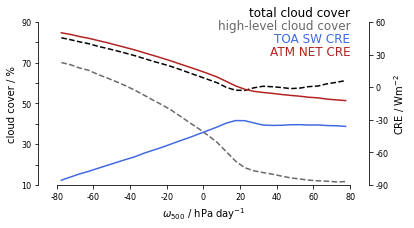

In [12]:
plt.figure(figsize=(5.915,3))
ax = plt.subplot(1,1,1)
ax.spines['left'].set_bounds(10, 90)
ax.spines['bottom'].set_bounds(-80,80)
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
plt.plot(bins[4:36], 100*clch_sampled[4:36], 'dimgray', linestyle='--')
plt.plot(bins[4:36], 100*clct_sampled[4:36], 'k', linestyle='--')
plt.xlim(-90,90); plt.ylim(10,90)
ax.xaxis.set_ticks([-80,-60,-40,-20,0,20,40,60,80])
ax.xaxis.set_ticklabels([-80,-60,-40,-20,0,20,40,60,80], fontsize=8)
ax.yaxis.set_ticks([10,20,30,40,50,60,70,80,90])
ax.yaxis.set_ticklabels([10,'',30,'',50,'',70,'',90], fontsize=8)
plt.xlabel(r'$\omega_{500}$ / hPa day$^{-1}$',fontsize=10)
plt.ylabel('cloud cover / %',fontsize=10)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
ax2.spines['right'].set_bounds(-90, 60)
ax2.spines['bottom'].set_color('none')
ax2.spines['top'].set_color('none')
ax2.spines['left'].set_color('none')
ax2.plot(bins[4:36],toaswcre_sampled[4:36],'royalblue') 
ax2.plot(bins[4:36],atmlwcre_sampled[4:36]+atmswcre_sampled[4:36],'firebrick')
plt.xlim(-90,90);plt.ylim(-90,60)
ax2.yaxis.set_ticks([-90,-60,-30,0,30,60])
ax2.yaxis.set_ticklabels([-90,-60,-30,0,30,60], fontsize=8)
plt.ylabel(r'CRE / Wm$^{-2}$',fontsize=10)

plt.text(80,65,'total cloud cover', ha='right', color='k', size=12)
plt.text(80,53,'high-level cloud cover', ha='right', color='dimgray', size=12)
plt.text(80,41,'TOA SW CRE', ha='right', color='royalblue', size=12)
plt.text(80,29,'ATM NET CRE', ha='right', color='firebrick', size=12)

plt.savefig('figure-1b.pdf')